In [2]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate

DH = DataHolder(**paths)

In [34]:
train_test = DH.stratified_train_test_split(feature = 'openface', speaker=1, test_size = .15, val_size = .17, none_count=50)
dataset = dicDataset(**train_test['data'])
class_weights = train_test['class_weights']

In [48]:
def eval_on_batch(batch, model, criterion):
    model.eval()
    with torch.no_grad():
        pred = model(batch['features'])
    return (criterion(batch['targets'], pred) / pred.shape[0]).detach().numpy()
    
def train(model, dataset, criterion, epoch=50, lr=1e-4, hist_train_loss = [], hist_test_loss = [], hist_val_loss = []):
    model.train()
    test, val = dataset.get_test(), dataset.get_valid()
    dataloader = DataLoader(dataset, batch_size = 50, shuffle = True, collate_fn = pad_collate)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for e in range(epoch):
        epoch_loss = 0.0

        for batch in dataloader:

            pred = model(batch['features'])
            loss = criterion(batch['targets'], pred)

            epoch_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (e+1)%(epoch//5)==0:
            print(f"loss epoch {e}: {epoch_loss:2f}")
    
        hist_train_loss.append(loss.detach().numpy()/len(dataset))
        hist_test_loss.append(eval_on_batch(test, model, criterion))
        hist_val_loss.append(eval_on_batch(val, model, criterion))
    return hist_train_loss, hist_test_loss, hist_val_loss

loss epoch 39: -3.088789
loss epoch 79: -3.117751
loss epoch 119: -3.128028
loss epoch 159: -3.135854
loss epoch 199: -3.132449


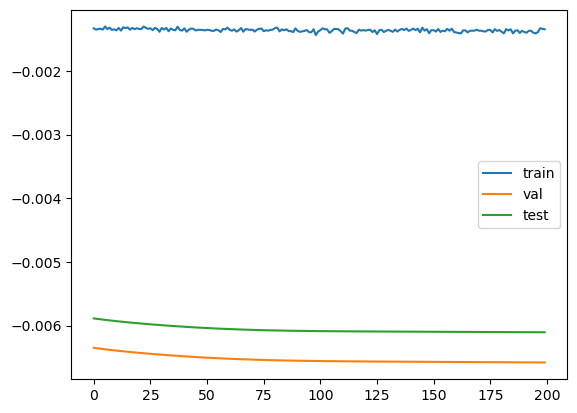

In [92]:
criterion = nn.KLDivLoss()
model =GRUModel(input_dim=17)
hist_train_loss, hist_test_loss, hist_val_loss = [],[],[]
hist_train_loss, hist_test_loss, hist_val_loss = train(model, dataset, criterion, lr=1e-4,epoch=200, hist_train_loss=hist_train_loss, hist_test_loss=hist_test_loss, hist_val_loss=hist_val_loss)
plt.plot(hist_train_loss, label='train')
plt.plot(hist_val_loss, label='val')
plt.plot(hist_test_loss, label='test')
plt.legend()
plt.show()

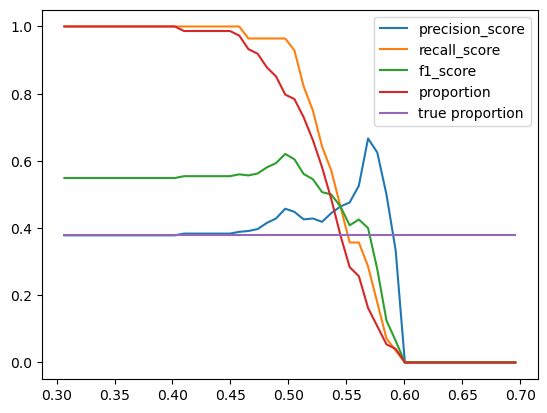

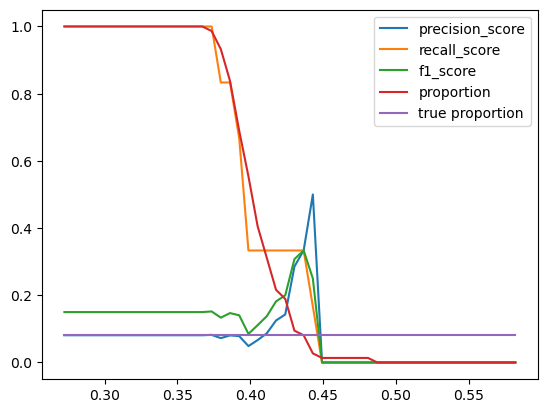

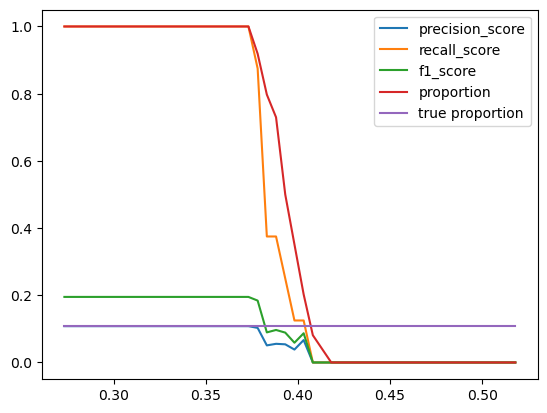

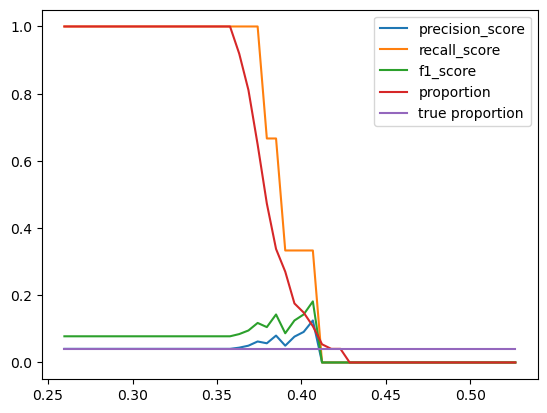

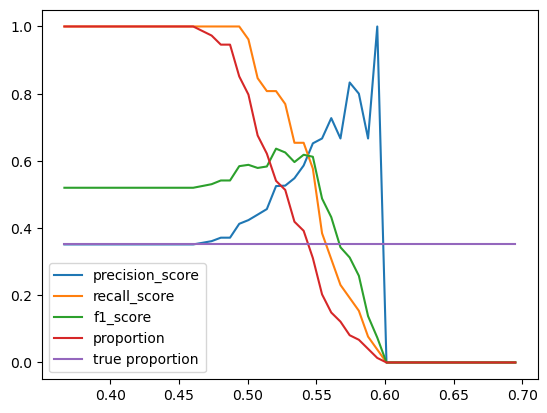

In [96]:
y_test = dataset.get_test()
pred_n = model(y_test['features']).detach().numpy()
y_true = y_test['targets'].detach().numpy()

def explore_tresh(true, pred):
    tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
    out = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['precision_score', 'recall_score', 'f1_score', 'proportion', 'true proportion'], index=tresh)
    return out

for i in range(5):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot()